In [2]:
import pandas as pd
import numpy as np
import re

In [ ]:
atl_lax_raw = pd.read_csv("ATL_to_LAX.csv")
atl_lax = atl_lax_raw[(atl_lax_raw["isNonStop"] == True) & (atl_lax_raw["segmentsCabinCode"] == "coach")]
atl_lax.to_csv("ATL_to_LAX_nonstop_coach.csv", index=False)

In [27]:
atl_lax = pd.read_csv("dataset/ATL_to_LAX_nonstop_coach.csv")
# atl_lax = pd.read_csv("https://raw.githubusercontent.com/guan404ming/flight-ticket-price-forecaster/ywnien/dataset/ATL_to_LAX_nonstop_coach.csv")
df_dateindex = atl_lax.copy()
df_dateindex.index = pd.to_datetime(df_dateindex["searchDate"])
df_dateindex

,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
searchDate,,,,,,,,,,,,,,,,,,,,,
2022-04-16,184852ad5f76a2f83f10848eced24103,2022-04-16,2022-04-17,ATL,LAX,KNR,PT4H54M,0,False,False,...,1650262800,2022-04-17T23:20:00.000-07:00,LAX,ATL,Spirit Airlines,NK,AIRBUS INDUSTRIE A320 SHARKLETS,17640,None,coach
2022-04-16,28aa3e9cc7e99ac751b90224b153646f,2022-04-16,2022-04-17,ATL,LAX,KNR,PT4H55M,0,False,False,...,1650209400,2022-04-17T08:30:00.000-07:00,LAX,ATL,Spirit Airlines,NK,AIRBUS INDUSTRIE A320 SHARKLETS,17700,None,coach
2022-04-16,d582dcb95026cae8ebe28925a02c1734,2022-04-16,2022-04-17,ATL,LAX,HA0QA0MQ,PT4H43M,0,False,False,...,1650251100,2022-04-17T20:05:00.000-07:00,ONT,ATL,Delta,DL,Airbus A321,16980,1919,coach
2022-04-16,14b11956eea40b97556975441f2e47b0,2022-04-16,2022-04-17,ATL,LAX,HA0QA0MQ,PT4H43M,0,False,False,...,1650261300,2022-04-17T22:55:00.000-07:00,ONT,ATL,Delta,DL,Airbus A321,16980,1919,coach
2022-04-16,423b15a2e33be0b1c971c4eadc7eb979,2022-04-16,2022-04-17,ATL,LAX,HA0QA0MQ,PT4H51M,0,False,False,...,1650221280,2022-04-17T11:48:00.000-07:00,ONT,ATL,Delta,DL,Airbus A321,17460,1919,coach
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-05,abc98a9d0e7b8fa88fd057154d14845f,2022-10-05,2022-11-12,ATL,LAX,KAVQA0BQ,PT5H2M,0,True,False,...,1668312060,2022-11-12T20:01:00.000-08:00,LAX,ATL,Delta,DL,NaN,18120,1943,coach
2022-10-05,994a8cdc859f84a590a209068012ad11,2022-10-05,2022-11-12,ATL,LAX,KAVQA0BQ,PT5H2M,0,True,False,...,1668286320,2022-11-12T12:52:00.000-08:00,LAX,ATL,Delta,DL,NaN,18120,1943,coach
2022-10-05,2f96f62a0672b1d8964f46ee0da02203,2022-10-05,2022-11-12,ATL,LAX,KAVQA0BQ,PT5H4M,0,True,False,...,1668282420,2022-11-12T11:47:00.000-08:00,LAX,ATL,Delta,DL,Airbus A321,18240,1943,coach


# Imputation
foward and back filling 沒有明顯減少 nan 的數目，代表有些機票的部分資訊是航空公司沒有提供的

In [28]:
df_dateindex['segmentsDistance'] = df_dateindex['segmentsDistance'].replace("None", np.nan)

print("Rows", "\t:", df_dateindex.shape[0])
print("-" * 40)
for column in df_dateindex:
    _na_count = df_dateindex[column].isna().sum()
    if _na_count > 0:
        print(column, " \t:", _na_count)

Rows 	: 147802
----------------------------------------
totalTravelDistance  	: 12908
segmentsEquipmentDescription  	: 12046
segmentsDistance  	: 12908


In [29]:
def sort_multi_index(df: pd.DataFrame):
    index = df.index

    min_max_record = {}
    for level0, level1 in index:
        if level0 not in min_max_record:
            min_max_record[level0] = [level1, pd.to_datetime("1970-01-01")]
        if level1 > min_max_record[level0][1]:
            min_max_record[level0][1] = level1
        elif level1 < min_max_record[level0][0]:
            min_max_record[level0][0] = level1

    level0_arr = index.get_level_values(0).unique().to_numpy()
    key_arr = np.array([min_max_record[name] for name in level0_arr])
    ind = np.lexsort((key_arr[:, 1], key_arr[:, 0]))
    return df.loc[level0_arr[ind]]


to_impute = df_dateindex.copy()
to_impute = to_impute.set_index("legId", append=True).swaplevel()
to_impute = sort_multi_index(to_impute)
to_impute_arr = to_impute.to_numpy()


### impute trials

In [30]:
pos = 0
for _id in to_impute.index.get_level_values(0).unique():
    subframe = to_impute.loc[_id]
    if subframe.isna().any().any():
        subframe = subframe.ffill().backfill()
    subarr = subframe.to_numpy()
    len_subarr= subarr.shape[0]
    to_impute_arr[pos:pos+len_subarr] = subarr
    pos += len_subarr

#### Check nan numbers

In [33]:
filled_df = pd.DataFrame(to_impute_arr, columns=to_impute.columns, index=to_impute.index)

### There are still many NaN
print("Rows", "\t:", filled_df.shape[0])
print("-" * 40)
for column in filled_df:
    _na_count = filled_df[column].isna().sum()
    if _na_count > 0:
        print(column, " \t:", _na_count)

Rows 	: 147802
----------------------------------------
totalTravelDistance  	: 12173
segmentsEquipmentDescription  	: 11363
segmentsDistance  	: 12173


#### 飛機機種可能會改變
剩下的 NaN 都是完全缺失的資訊，無法參照同張機票的資料進行補值

In [9]:
completely_loss_id = []
feature_names = ("totalTravelDistance", "segmentsEquipmentDescription")
for feat in feature_names:
    for _id in filled_df.index.get_level_values(0).unique():
        subframe = filled_df.loc[_id]
        if subframe[feat].unique().shape[0] == 1 and subframe[feat].isna().any():
            completely_loss_id.append(_id)
    print(feat)
    print(completely_loss_id)
    completely_loss_id.clear()

totalTravelDistance
['184852ad5f76a2f83f10848eced24103', '28aa3e9cc7e99ac751b90224b153646f', '535a65082254a9d101e96e0e7a3a4288', '22a5e0567dce5be031d31af98150722c', '9247ab5a948b42dafc240e3bc9e28228', '91f7e3f27c6b3870f26f51c90e70f522', 'd1657c92271c4996ee8bbd2670f5f46c', '68d7deeedee5b0357d0e39324ea493c7', '9c9279294fdfe74f6dfa3bc4b3c636a9', 'c2419b223a3deaefc972e0e25b4181d9', '8b413ea99a58d194b2aa06fd126bc797', '5b925ee27412293d04bb6acd9acd93ef', '52d2bad7b0aee8182a41978d953b844c', '9c44d6249677ead60fe715c1504c569f', 'c45999934a7dd50007b37a37ff852003', '0ca5180cb6f1db58a1101a0600849fac', '0a90f616d43ecb0bae98713438511c2b', '35030aa009151a5444bdac9c833c1a47', 'da272ff482185d50a62a878952d37e41', 'df59eb808d4b6ba4663f2b4de1ffc0f1', 'b8c762e1e1c22be5948a1c3e5cd88257', '92e766a856c1f735708fb167f6a4cf11', '87dd6d620b7652ce66bd775de1cd02a3', '997dfe03ba2c4a317011364940217428', '66000cc8883cfc52ff513f5cdeaceeb4', '6376cc542d338145091bae75cf155c44', 'e2b9fda635d07737a11eaf19288c0555', '8671c6

目前無法確認是資料誤植還是航空公司更改航班資訊

In [10]:
not_const_id = {}
feature_names = [
    'travelDuration',
    'elapsedDays',
    'isRefundable',
    'isNonStop',
    'totalTravelDistance',
    'segmentsDepartureTimeEpochSeconds',
    'segmentsDepartureTimeRaw',
    'segmentsArrivalTimeEpochSeconds',
    'segmentsArrivalTimeRaw',
    'segmentsArrivalAirportCode',
    'segmentsDepartureAirportCode',
    'segmentsAirlineName',
    'segmentsAirlineCode',
    'segmentsEquipmentDescription',
    'segmentsDurationInSeconds',
    'segmentsDistance',
]

for feat in feature_names:
    for _id in filled_df.index.get_level_values(0).unique():
        subframe = filled_df.loc[_id]
        if subframe[feat].unique().shape[0] != 1:
            not_const_id[_id] = subframe[feat].unique().tolist()
    if not_const_id:
        print(feat)
        print(not_const_id)
        not_const_id.clear()

totalTravelDistance
{'99532d13e806f8d8bd4929df0135a4ef': [1919.0, 1897.0], '1e0599fb674514d33033add40d120bd1': [1919.0, 1897.0], 'b5226907740a2790cedcc2f5a7a8b84d': [1919.0, 1897.0], 'a94cc5d0617d88b55c58d09c59a045fe': [1919.0, 1897.0], 'af2fd5a8cbc6f25c0c8f30d6c310bf90': [1919.0, 1897.0], 'd722c53fa82cf56a315e66e04996753c': [1919.0, 1897.0], '3ee8374e83018b23500ca02eb360f510': [1919.0, 1897.0], 'de549e849ffc11dfe4e005cbd2357632': [1919.0, 1897.0], 'a624058b6bb47196006009c727c1bc18': [1919.0, 1897.0], '258a7b3e038b43a3642d891c9c81e6d3': [1919.0, 1897.0], '84c64d749f74ed5032356a115ce1f4bb': [1919.0, 1897.0], 'c0f0d0d7edfb36fff4d68a430194c0cd': [1919.0, 1897.0], 'ac45e317182f7e526e68e32c81c4cc47': [1919.0, 1897.0], '6d31dc87bf83332a3368c238fb3f5c03': [1919.0, 1897.0], 'ab97a7a10cb248eb4d3498d49d6b9d9b': [1919.0, 1897.0], '30709f0910b1760febca3d966626344e': [1919.0, 1897.0], '78734cc6f2f3b61a6a8231feff6b6be7': [1919.0, 1897.0], '0243a245d2e3b06df69924840e7bd5ff': [1919.0, 1897.0], '6d9f8d

# Separate Training set

Each prediction gives next 7 days prediction. Perform 5 fold back testing. Hence, 7 * (5 + 1) = 42 days are reserved for validation and test set.

Before splitting, remove redundant features

In [34]:
constant_features = [ # These features are all the same in this sub dataset
    "startingAirport",
    "destinationAirport",
    "isRefundable",
    "isNonStop",
    "segmentsDepartureAirportCode",
    "segmentsCabinCode",
]
redundant_features = [
    "searchDate", # level 1 of multi-index
    "flightDate",
    "travelDuration", # duplicated to segmentsDurationsInSecodns
    "segmentsDistance", # duplicated to totalTravelDistance (with same values)
    "segmentsAirlineName", # fullname of AirlineCode. AirlineCode was choosed.
]

unexpectable_features = [ # Not the targets, but cannot be used as exogenous variables
    "baseFare",
    "fareBasisCode",
    "isBasicEconomy"
]

filled_df = filled_df.drop(columns=constant_features)
filled_df = filled_df.drop(columns=redundant_features)
filled_df = filled_df.drop(columns=unexpectable_features)
filled_df.to_parquet("filled_df.parquet")

# CHECKPOINT: imputed_dataset

In [ ]:
filled_df = pd.read_parquet("filled_df.parquet")

In [10]:
from tstide.dataframe import train_set

# def train_set(
#     df: pd.DataFrame,
#     date_index: pd.DatetimeIndex,
#     reserved_days: int = 42, # 7 * 6
# ):
#     if not isinstance(date_index, pd.DatetimeIndex):
#         date_index = pd.DatetimeIndex(date_index)
#     split_day = date_index.max() - pd.to_timedelta(reserved_days, unit="D")
#     return df[date_index <= split_day]


train_df = train_set(filled_df, filled_df.index.get_level_values(1))
train_df

,,elapsedDays,totalFare,seatsRemaining,totalTravelDistance,segmentsDepartureTimeEpochSeconds,segmentsDepartureTimeRaw,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds
legId,searchDate,,,,,,,,,,,,
184852ad5f76a2f83f10848eced24103,2022-04-16,0,328.59,0,NaN,1650245160,2022-04-17T21:26:00.000-04:00,1650262800,2022-04-17T23:20:00.000-07:00,LAX,NK,AIRBUS INDUSTRIE A320 SHARKLETS,17640
28aa3e9cc7e99ac751b90224b153646f,2022-04-16,0,328.59,0,NaN,1650191700,2022-04-17T06:35:00.000-04:00,1650209400,2022-04-17T08:30:00.000-07:00,LAX,NK,AIRBUS INDUSTRIE A320 SHARKLETS,17700
d582dcb95026cae8ebe28925a02c1734,2022-04-16,0,498.6,9,1919.0,1650234120,2022-04-17T18:22:00.000-04:00,1650251100,2022-04-17T20:05:00.000-07:00,ONT,DL,Airbus A321,16980
14b11956eea40b97556975441f2e47b0,2022-04-16,0,498.6,9,1919.0,1650244320,2022-04-17T21:12:00.000-04:00,1650261300,2022-04-17T22:55:00.000-07:00,ONT,DL,Airbus A321,16980
423b15a2e33be0b1c971c4eadc7eb979,2022-04-16,0,498.6,9,1919.0,1650203820,2022-04-17T09:57:00.000-04:00,1650221280,2022-04-17T11:48:00.000-07:00,ONT,DL,Airbus A321,17460
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72a74cc52657270cbec49245b30c7b6c,2022-08-20,0,308.6,9,1943.0,1665510120,2022-10-11T13:42:00.000-04:00,1665527400,2022-10-11T15:30:00.000-07:00,LAX,DL,Boeing 757-200,17280
940daa57d4e0d55afa3ad029f2b4cd82,2022-08-20,0,308.6,9,1943.0,1665535500,2022-10-11T20:45:00.000-04:00,1665552900,2022-10-11T22:35:00.000-07:00,LAX,DL,Boeing 757,17400
c5cee3cc5e1a85bcac34342fb98ccada,2022-08-20,0,308.6,7,1943.0,1665522660,2022-10-11T17:11:00.000-04:00,1665540300,2022-10-11T19:05:00.000-07:00,LAX,AA,Airbus A321,17640


# Examine the correlation, feature importance

In [40]:
from sklearn.preprocessing import OrdinalEncoder

categorical_features = [
    "segmentsArrivalAirportCode",
    'segmentsAirlineCode',
    'segmentsEquipmentDescription'
]

_df = train_df.copy().dropna()

# _df = _df.drop(columns=["legId", "searchDate"])
ord_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
_df[categorical_features] = ord_enc.fit_transform(_df[categorical_features])

In [41]:
def searchDate_to_seconds(df: pd.DataFrame):
    date_index = pd.to_datetime(df.index.get_level_values(1))
    df["searchDateInSeconds"] = (date_index - pd.to_datetime("1970-01-01")).total_seconds()

searchDate_to_seconds(_df)
_df_departure_raw = _df.pop("segmentsDepartureTimeRaw")
_df_arrival_raw = _df.pop("segmentsArrivalTimeRaw")
_df = _df.astype(np.float32)
_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 102400 entries, ('d582dcb95026cae8ebe28925a02c1734', '2022-04-16') to ('90f81a6f04ac2d2c81ae11059e7a7047', '2022-08-20')
Data columns (total 11 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   elapsedDays                        102400 non-null  float32
 1   totalFare                          102400 non-null  float32
 2   seatsRemaining                     102400 non-null  float32
 3   totalTravelDistance                102400 non-null  float32
 4   segmentsDepartureTimeEpochSeconds  102400 non-null  float32
 5   segmentsArrivalTimeEpochSeconds    102400 non-null  float32
 6   segmentsArrivalAirportCode         102400 non-null  float32
 7   segmentsAirlineCode                102400 non-null  float32
 8   segmentsEquipmentDescription       102400 non-null  float32
 9   segmentsDurationInSeconds          102400 non-null  float32
 10  searchDateI

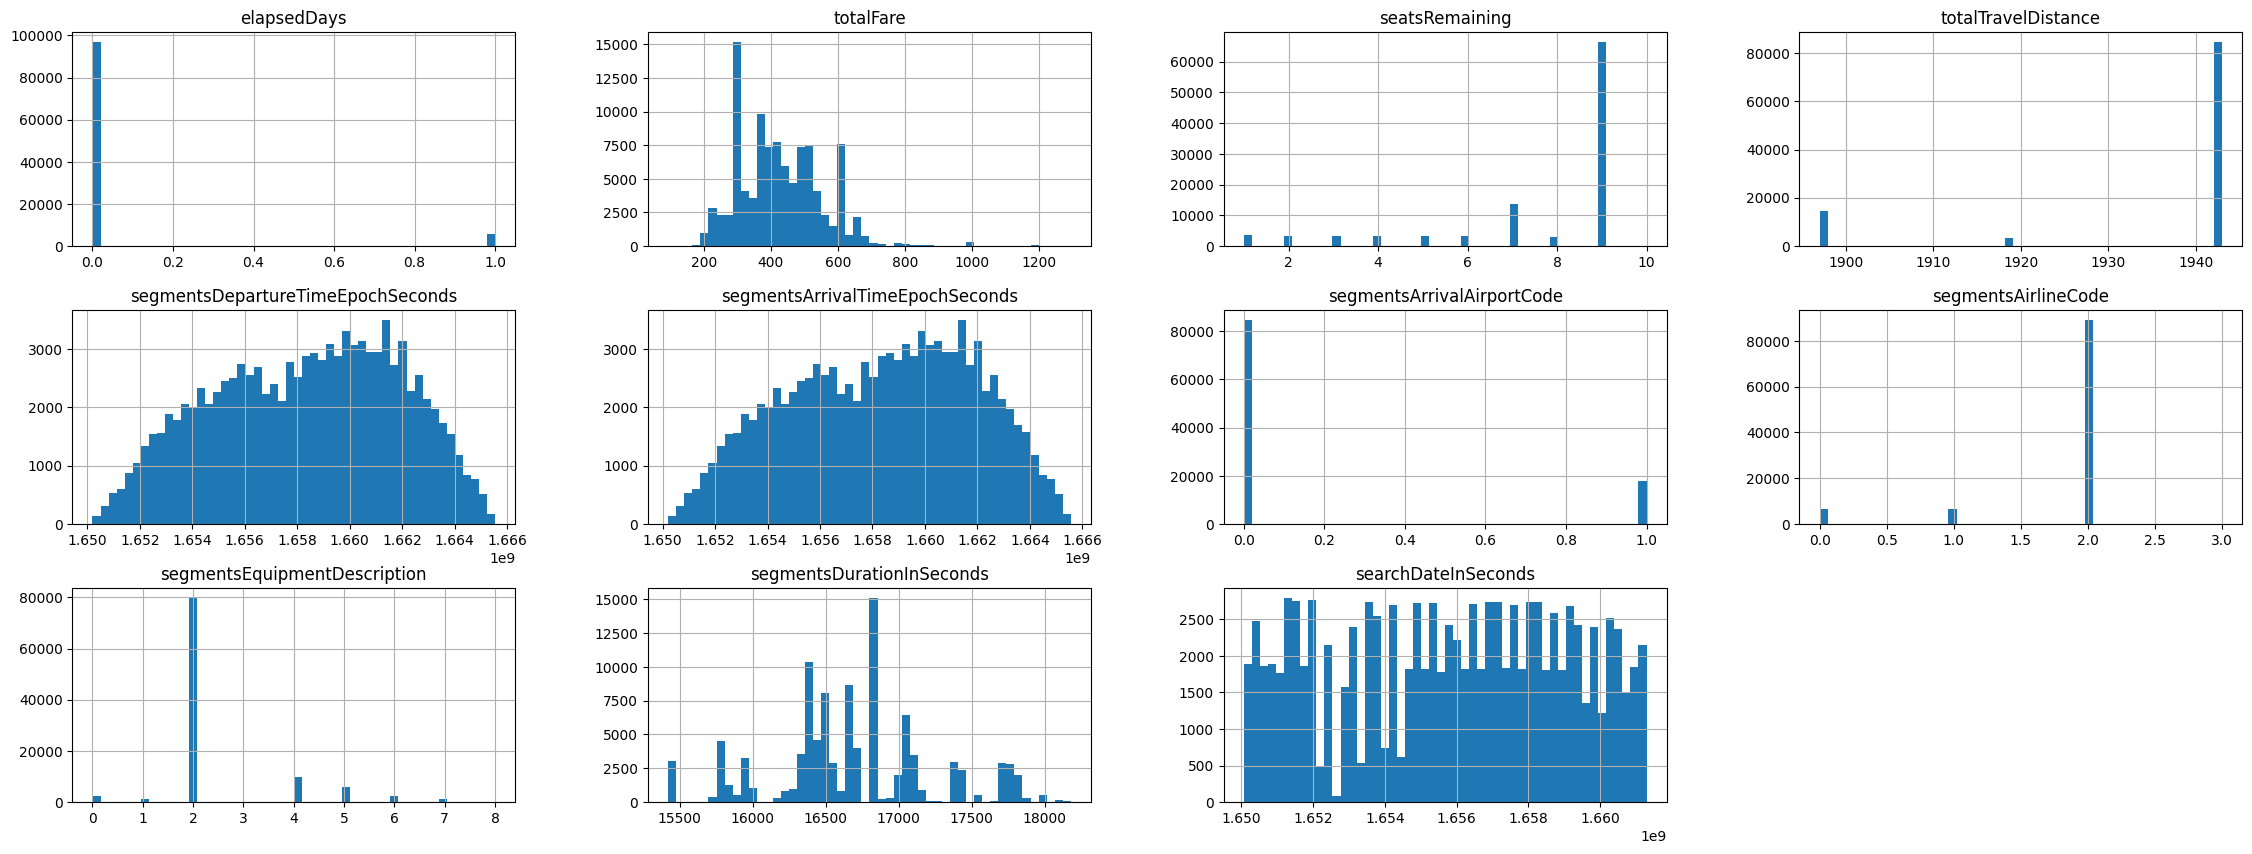

In [18]:
_df.hist(bins=50, figsize=(28, 10), layout=(3, 4));

### Categorical features 不容易呈現有線性相關
totalTravelDistance 與 segmentsArrivalAirportCode 高度相關，但並非線性而是多對一的關係 (3 -> 2)。兩者當中將選用種類較少的 segmentsArrivalAirportCode 當作代表。

關於為甚麼都是抵達 LAX 的機票會有不同的 ArrivalAirportCode，是因為 LAX 會和鄰近的機場 ONT 借用大型的跑道。但是資訊上都是寫到 LAX (也許航空公司會負往 LAX 的交通吧)

另外，三者與 totalFare 之間的線性關係都不明顯。

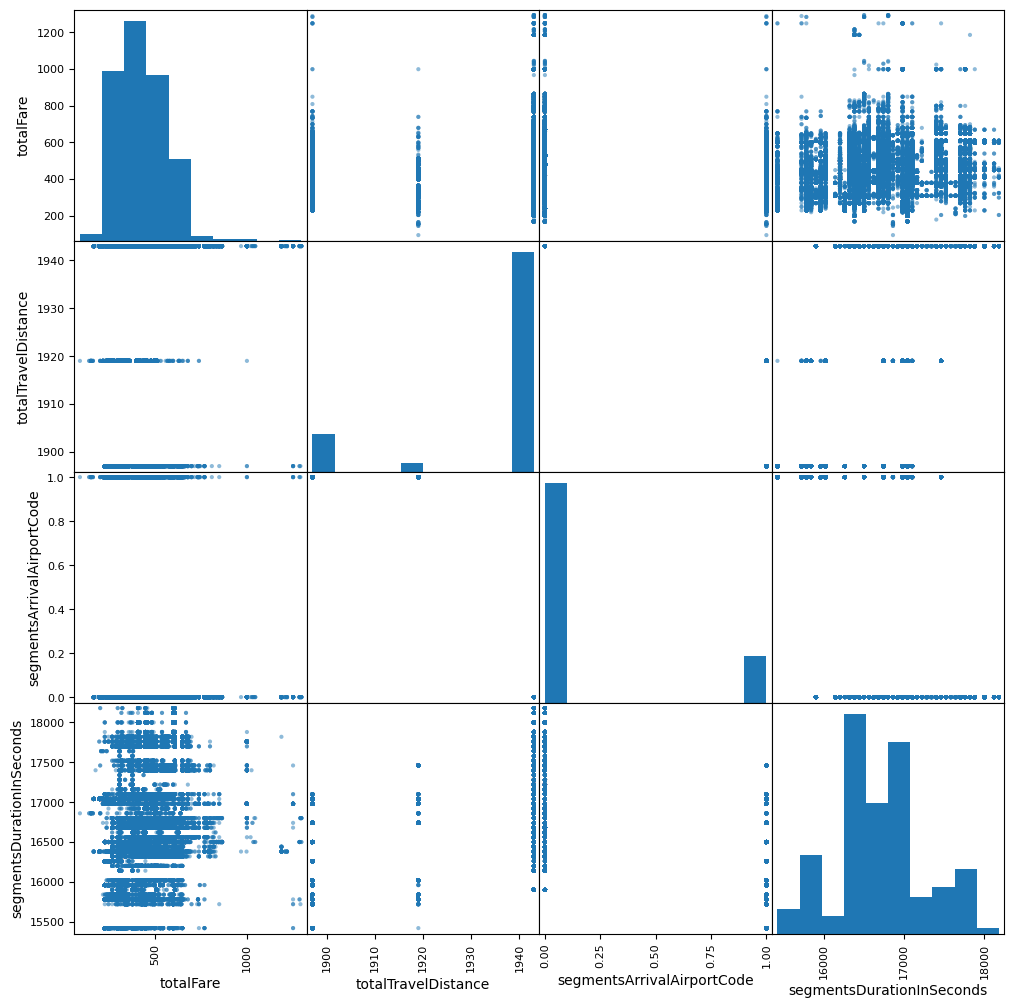

In [28]:
from pandas.plotting import scatter_matrix

scatter_matrix(
    _df[[
        "totalFare",
        "totalTravelDistance",
        "segmentsArrivalAirportCode",
        "segmentsDurationInSeconds",
    ]],
    figsize=(12, 12),
);

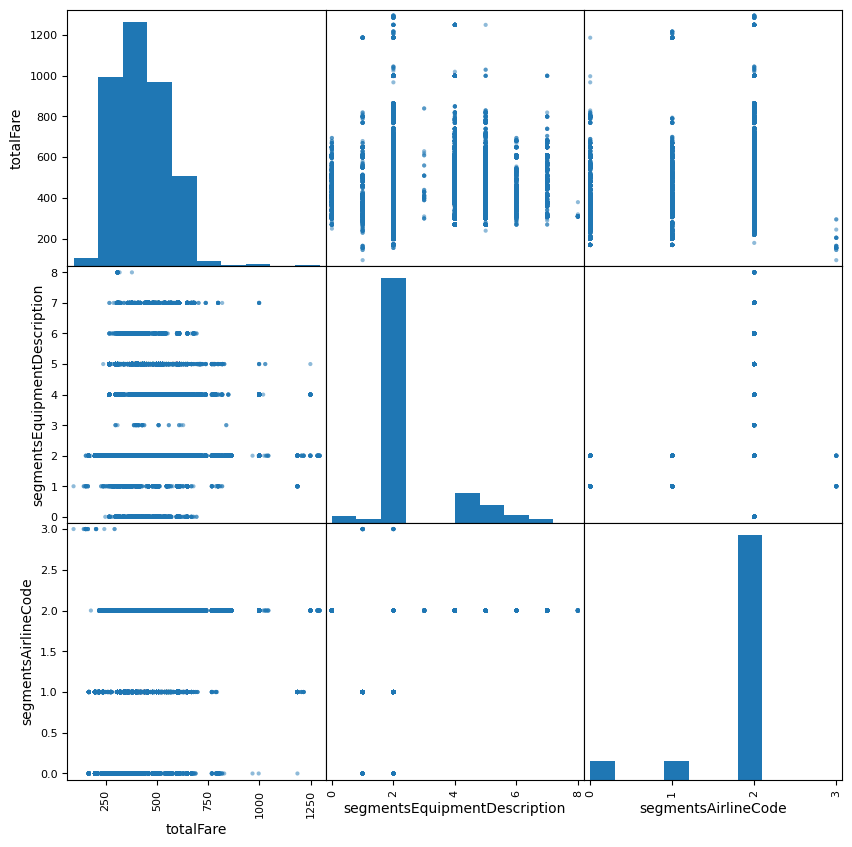

In [27]:
scatter_matrix(
    _df[[
        "totalFare",
        "segmentsEquipmentDescription",
        "segmentsAirlineCode",
    ]],
    figsize=(10, 10),
);

ArrivalTime 與 Departure Time 沒有相差太多，將以 DepartureTime 與 travelDuration 來描述同等的資訊

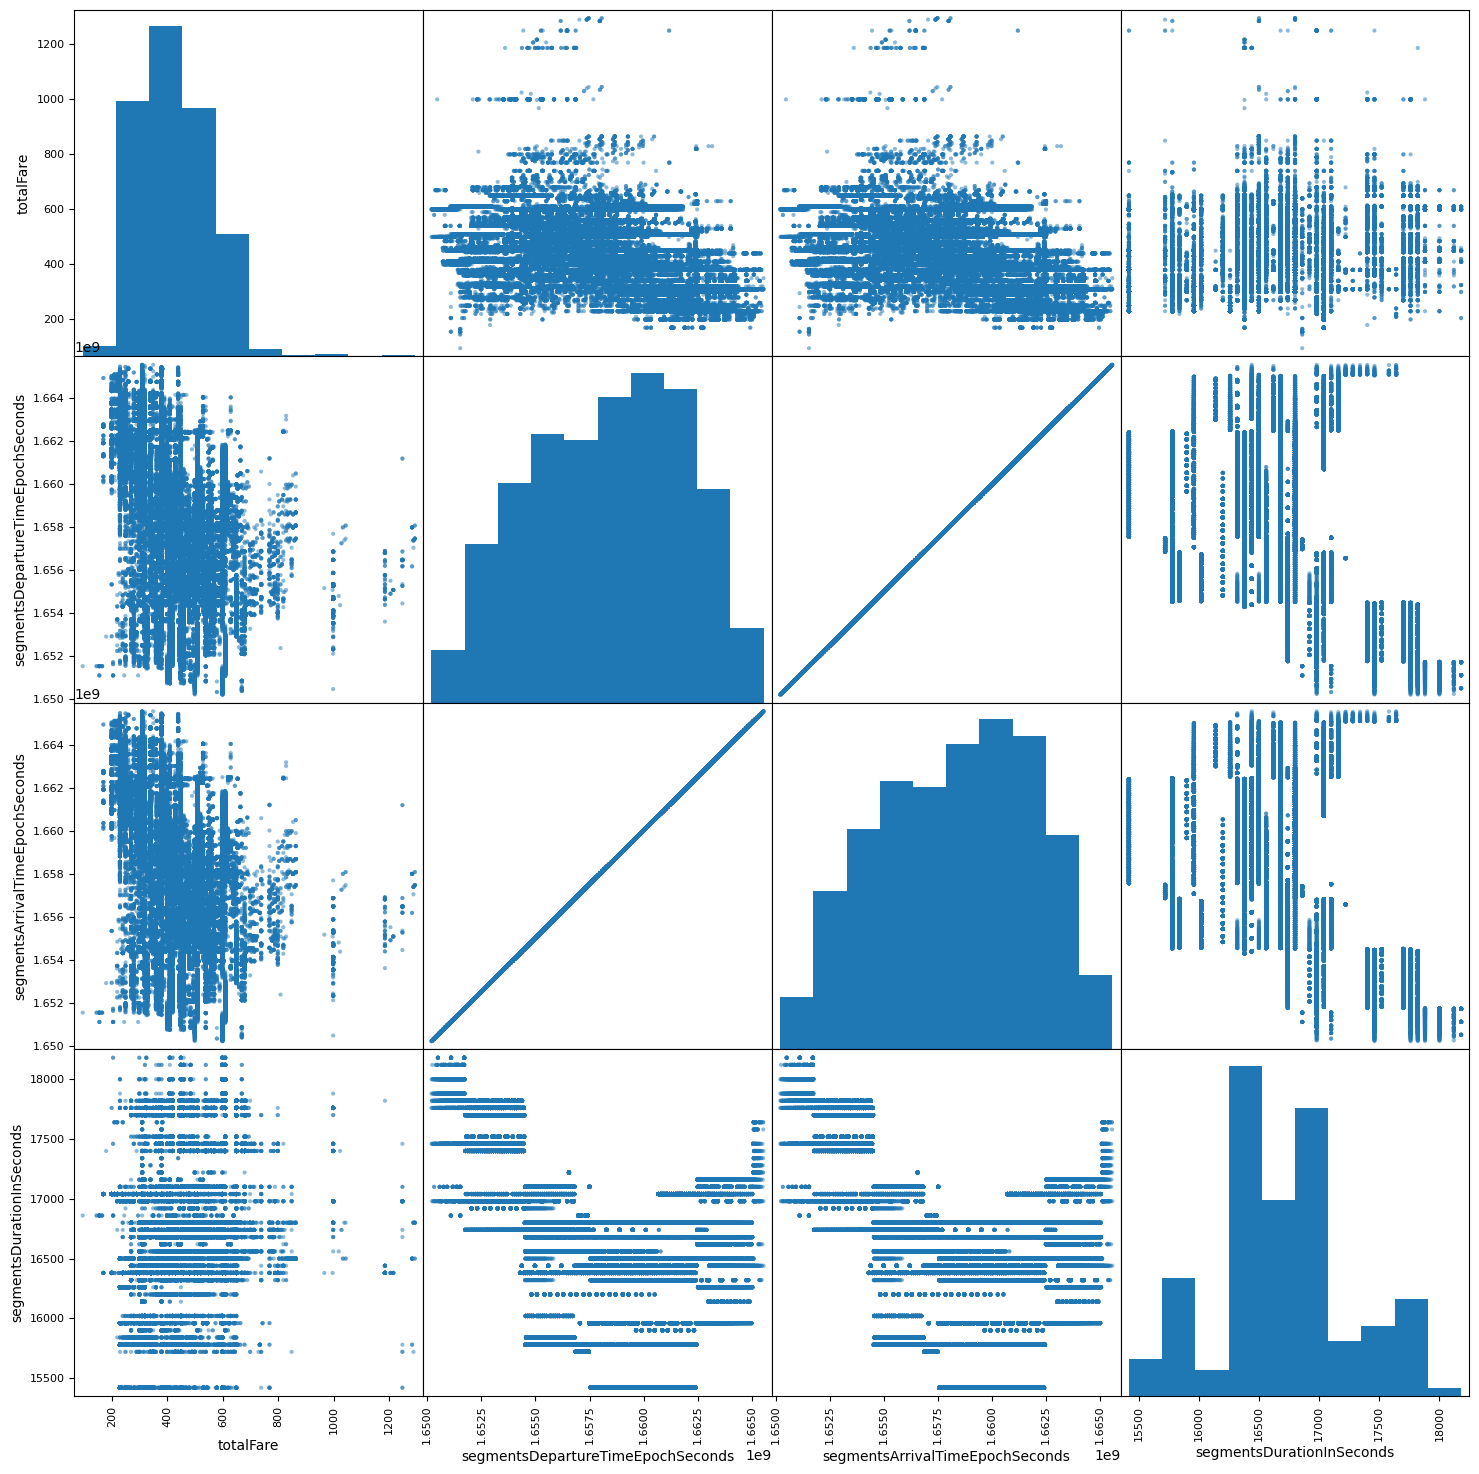

In [26]:
scatter_matrix(
    _df[[
        "totalFare",
        "segmentsDepartureTimeEpochSeconds",
        "segmentsArrivalTimeEpochSeconds",
        "segmentsDurationInSeconds",
    ]],
    figsize=(18, 18),
);

## Encode time info
### Calculate remaining days as new feature
線性關係仍然不明顯

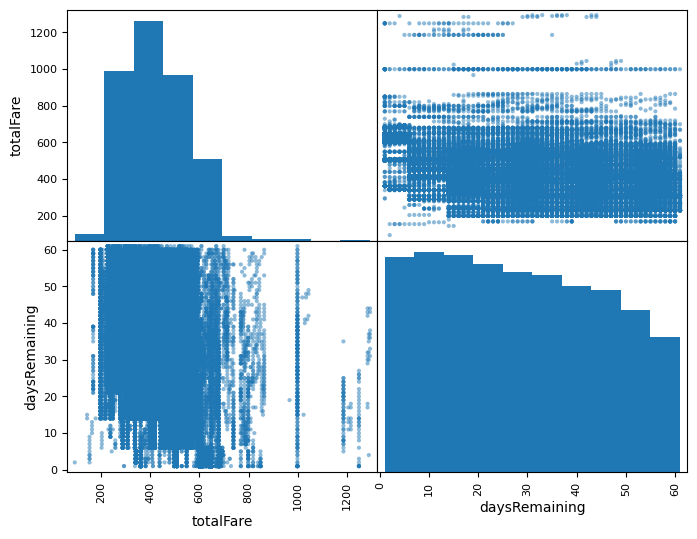

In [43]:
from pandas.plotting import scatter_matrix

def calc_days_remaining(df: pd.DataFrame):
    df["daysRemaining"] = pd.to_timedelta(
        pd.to_datetime(df["segmentsDepartureTimeEpochSeconds"], unit="s")
        - pd.to_datetime(df.index.get_level_values(level=1))
    ).dt.days.astype(np.float32)

calc_days_remaining(_df)

scatter_matrix(
    _df[[
        "totalFare",
        "daysRemaining",
    ]],
    figsize=(8, 6),
);

In [44]:
def split_YMD(string: str, df: pd.DataFrame):
    df[string] = pd.to_datetime(df[string])
    df[string + 'Year'] = df[string].dt.year
    df[string + 'Month'] = df[string].dt.month
    df[string + 'Day'] = df[string].dt.day
    df.drop(string, axis=1, inplace=True)

_df["searchDate"] = _df.index.get_level_values(1)
split_YMD("searchDate", _df)

日光節約時間導致時區改變，但是判斷早晚的方式還是以目前幾點為準，因此捨去時區資訊。

In [58]:
def split_time(string: str, df: pd.DataFrame):
    df[string] = pd.to_datetime(df[string].str[:-6]) # cut timezone info
    df[string + 'Year'] = df[string].dt.year
    df[string + 'Month'] = df[string].dt.month
    df[string + 'Day'] = df[string].dt.day
    df[string + 'Hour'] = df[string].dt.hour
    df[string + 'Minute'] = df[string].dt.minute
    df.drop(string, axis=1, inplace=True)

_df["Departure"] = _df_departure_raw
split_time("Departure", _df)
_df["Arrival"] = _df_arrival_raw
split_time("Arrival", _df)
### flightDate is the subset of segmentsDepartureTimeRaw.
# split_time('flightDate', df_dateindex)
_df = _df.astype(np.float32)
_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 102400 entries, ('d582dcb95026cae8ebe28925a02c1734', '2022-04-16') to ('90f81a6f04ac2d2c81ae11059e7a7047', '2022-08-20')
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   elapsedDays                        102400 non-null  float32
 1   totalFare                          102400 non-null  float32
 2   seatsRemaining                     102400 non-null  float32
 3   totalTravelDistance                102400 non-null  float32
 4   segmentsDepartureTimeEpochSeconds  102400 non-null  float32
 5   segmentsArrivalTimeEpochSeconds    102400 non-null  float32
 6   segmentsArrivalAirportCode         102400 non-null  float32
 7   segmentsAirlineCode                102400 non-null  float32
 8   segmentsEquipmentDescription       102400 non-null  float32
 9   segmentsDurationInSeconds          102400 non-null  float32
 10  searchDateI

* Departure, Arrival 各自與 totalFare 的 correlation coefficients 都差不多，和前面的結果吻合。前面提到，將只選用 Departure Time。
* totalTravelDistance, segmentsDurationInSeconds, segmentsArrivalAirportCode 也差不多，將選用沒有缺值的 segmentsArrivalAirportCode

DepartureDay                         0.015181
ArrivalDay                           0.016538
seatsRemaining                       0.026140
searchDateDay                        0.030578
elapsedDays                          0.056445
segmentsEquipmentDescription         0.061431
ArrivalHour                          0.066530
DepartureMinute                      0.096746
ArrivalMinute                        0.120094
segmentsAirlineCode                  0.123880
DepartureHour                        0.146693
totalTravelDistance                  0.210955
segmentsDurationInSeconds            0.215557
segmentsArrivalAirportCode           0.218485
searchDateMonth                      0.317078
searchDateInSeconds                  0.320988
daysRemaining                        0.431966
ArrivalMonth                         0.456139
DepartureMonth                       0.456157
segmentsDepartureTimeEpochSeconds    0.470803
segmentsArrivalTimeEpochSeconds      0.470804
totalFare                         

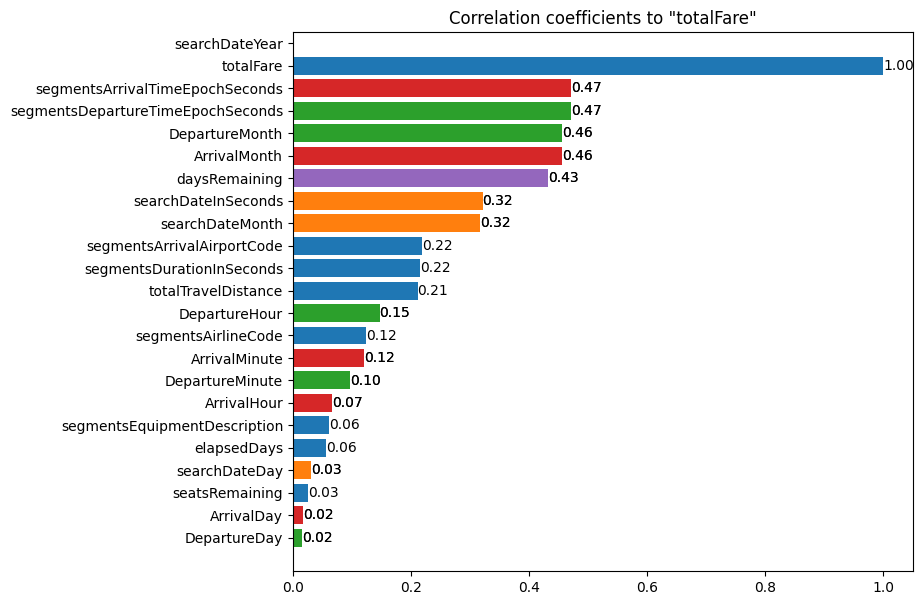

In [72]:
import matplotlib.pyplot as plt

correlation_matrix = _df.corr()
corr_totalFare = correlation_matrix["totalFare"].abs().sort_values()
display(corr_totalFare)

fig, ax = plt.subplots(figsize=(8, 7))
# fig.suptitle("Correlation coefficients to 'totalFare'")
ax.set_title('Correlation coefficients to "totalFare"')
ax.barh(corr_totalFare.index, corr_totalFare)
_sub_corr = corr_totalFare[["searchDateInSeconds", "searchDateYear", "searchDateMonth", "searchDateDay"]]
ax.barh(_sub_corr.index, _sub_corr)
_sub_corr = corr_totalFare[["segmentsDepartureTimeEpochSeconds", "DepartureYear", "DepartureMonth", "DepartureDay", "DepartureHour", "DepartureMinute"]]
ax.barh(_sub_corr.index, _sub_corr)
_sub_corr = corr_totalFare[["segmentsArrivalTimeEpochSeconds", "ArrivalYear", "ArrivalMonth", "ArrivalDay", "ArrivalHour", "ArrivalMinute"]]
ax.barh(_sub_corr.index, _sub_corr)
ax.barh("daysRemaining", corr_totalFare["daysRemaining"])

for bars in ax.containers:
    ax.bar_label(bars, fmt="%.2f")

前面 totalFare, totalTravelDistance, segmentsArrivalAirportCode, segmentsDurationInSeconds 的分布圖看不出線性的關係，然而他們對於 totalFare 的相關係數卻相差無幾

但他們確實不太相似

<BarContainer object of 3 artists>

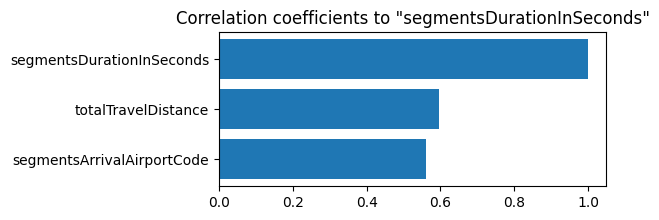

In [85]:
_features = ["totalTravelDistance", "segmentsArrivalAirportCode", "segmentsDurationInSeconds"]
corr_totalTravelDistance = correlation_matrix["segmentsDurationInSeconds"][_features].abs().sort_values()
fig, ax = plt.subplots(figsize=(5, 2))
# fig.suptitle("Correlation coefficients to 'totalFare'")
ax.set_title('Correlation coefficients to "segmentsDurationInSeconds"')
ax.barh(corr_totalTravelDistance.index, corr_totalTravelDistance)

由 Departure 與 arrival 算出來的剩餘天數 daysRemaining 似乎與其他時間特徵並不相似。並不像 Departure 與 Arrival 有高度的相關性

DepartureDay                         0.000760
ArrivalDay                           0.000783
searchDateDay                        0.002742
searchDateInSeconds                  0.004727
searchDateMonth                      0.004877
ArrivalHour                          0.005587
DepartureHour                        0.014030
DepartureMinute                      0.015567
ArrivalMinute                        0.062079
DepartureMonth                       0.398643
ArrivalMonth                         0.398697
segmentsDepartureTimeEpochSeconds    0.407789
daysRemaining                        1.000000
searchDateYear                            NaN
DepartureYear                             NaN
ArrivalYear                               NaN
Name: daysRemaining, dtype: float64

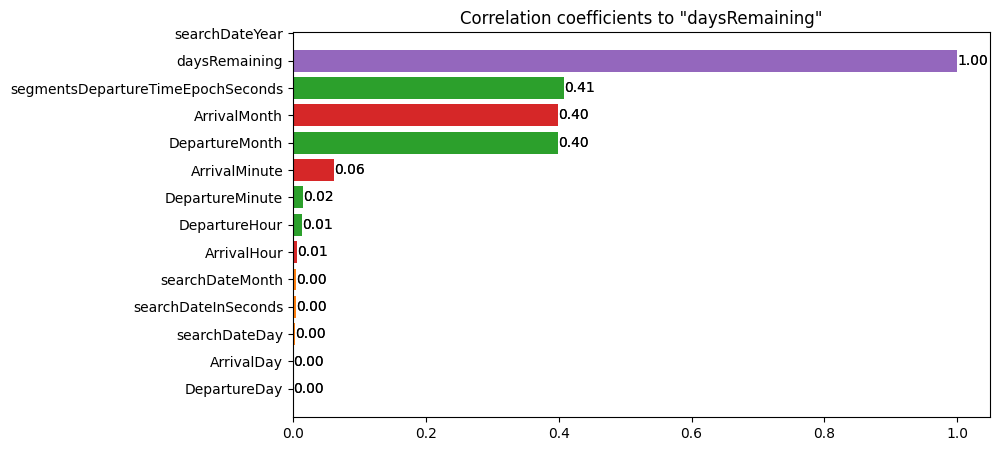

In [36]:
time_features = {
    "searchDate": [
        "searchDateInSeconds",
        "searchDateYear",
        "searchDateMonth",
        "searchDateDay",
    ],
    "departure": [
        "segmentsDepartureTimeEpochSeconds",
        "DepartureYear",
        "DepartureMonth",
        "DepartureDay",
        "DepartureHour",
        "DepartureMinute",
    ],
    "arrival": [
        "ArrivalYear",
        "ArrivalMonth",
        "ArrivalDay",
        "ArrivalHour",
        "ArrivalMinute",
    ],
    "daysRemaining": [
        "daysRemaining"
    ]
}
total_time_features = [name for inner_list in time_features.values() for name in inner_list]
corr_daysRemaining = correlation_matrix["daysRemaining"][total_time_features].abs().sort_values()
display(corr_daysRemaining)

fig, ax = plt.subplots(figsize=(9, 5))
ax.set_title('Correlation coefficients to "daysRemaining"')
ax.barh(corr_daysRemaining.index, corr_daysRemaining)
for time_feat_group in time_features.values():
    ax.barh(corr_daysRemaining[time_feat_group].index, corr_daysRemaining[time_feat_group])

for bars in ax.containers:
    ax.bar_label(bars, fmt="%.2f")

Correlation coefficient 不能看見非線性的關係，因此也使用 RandomForest 的 feature importance 來比較各個特徵

訓練模型之前，先儲存處理好的資料集，restart kernel 把不用的 memory 釋出

In [ ]:
_df.to_parquet("_df.parquet")

# CHECKPOINT: read na dropped pure numerical dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

_df = pd.read_parquet("_df.parquet")

Create autoregressive time series

In [2]:
from sklearn.ensemble import RandomForestRegressor
from tstide.transformer import TimeSeriesTransformer

lags = 14

ts_trans = TimeSeriesTransformer(
    lags,
    ["totalFare", "seatsRemaining"],
    [
        "elapsedDays",
        "segmentsDepartureTimeEpochSeconds",
        "segmentsArrivalAirportCode",
        "segmentsAirlineCode",
        "segmentsEquipmentDescription",
        "segmentsDurationInSeconds",
        "daysRemaining",
        "searchDateInSeconds",
        "searchDateYear",
        "searchDateMonth",
        "searchDateDay",
        "DepartureYear",
        "DepartureMonth",
        "DepartureDay",
        "DepartureHour",
        "DepartureMinute",
    ],
    [
        "daysRemaining",
        "searchDateInSeconds",
        "searchDateYear",
        "searchDateMonth",
        "searchDateDay",
    ],
    y_steps=7
)

def importances_diff_lags_y_steps(lags: list, y_steps: list):
    if len(lags) != len(y_steps):
        raise ValueError("The lengths of lags and y_steps should be the same")
    exog_feature_names = np.array(ts_trans.X_columns[2*ts_trans.lags:], dtype=object)
    exog_feature_importances_list = []
    for _lags, _y_steps in zip(lags, y_steps):
        ts_trans.lags = _lags
        ts_trans.y_steps = _y_steps
        X_train, y_train = ts_trans.train_X_y(_df)
        forest = RandomForestRegressor(bootstrap=False, n_jobs=14)
        forest.fit(X_train, y_train)
        exog_feature_importances_list.append(forest.feature_importances_[2*ts_trans.lags:])
    return lags, y_steps, exog_feature_names, exog_feature_importances_list

def plot_exog_importance(lags, y_steps, exog_feature_names, exog_feature_importances_list, exclude_first=False, figsize=None):
    if not figsize:
        figsize = (24, 6)
    sorted_idxs = np.argsort(exog_feature_importances_list[0])
    fig, axes = plt.subplots(1, len(lags), figsize=figsize, sharey=True)
    if not isinstance(axes, list):
        axes = [axes]
    fig.suptitle("Feature importances of exogenous variables")
    for i in range(len(lags)):
        axes[i].set_title(f"lags: {lags[i]}, y_steps: {y_steps[i]}")
        if exclude_first:
            bars = axes[i].barh(exog_feature_names[sorted_idxs][:-1], exog_feature_importances_list[i][sorted_idxs][:-1])
        else:
            bars = axes[i].barh(exog_feature_names[sorted_idxs], exog_feature_importances_list[i][sorted_idxs])
        axes[i].tick_params(axis="x", labelrotation=90)
        axes[i].bar_label(bars, fmt="%.3f")
    fig.subplots_adjust(wspace=0, hspace=0)

In [8]:
res = importances_diff_lags_y_steps([7, 10, 14], [1, 3, 7])

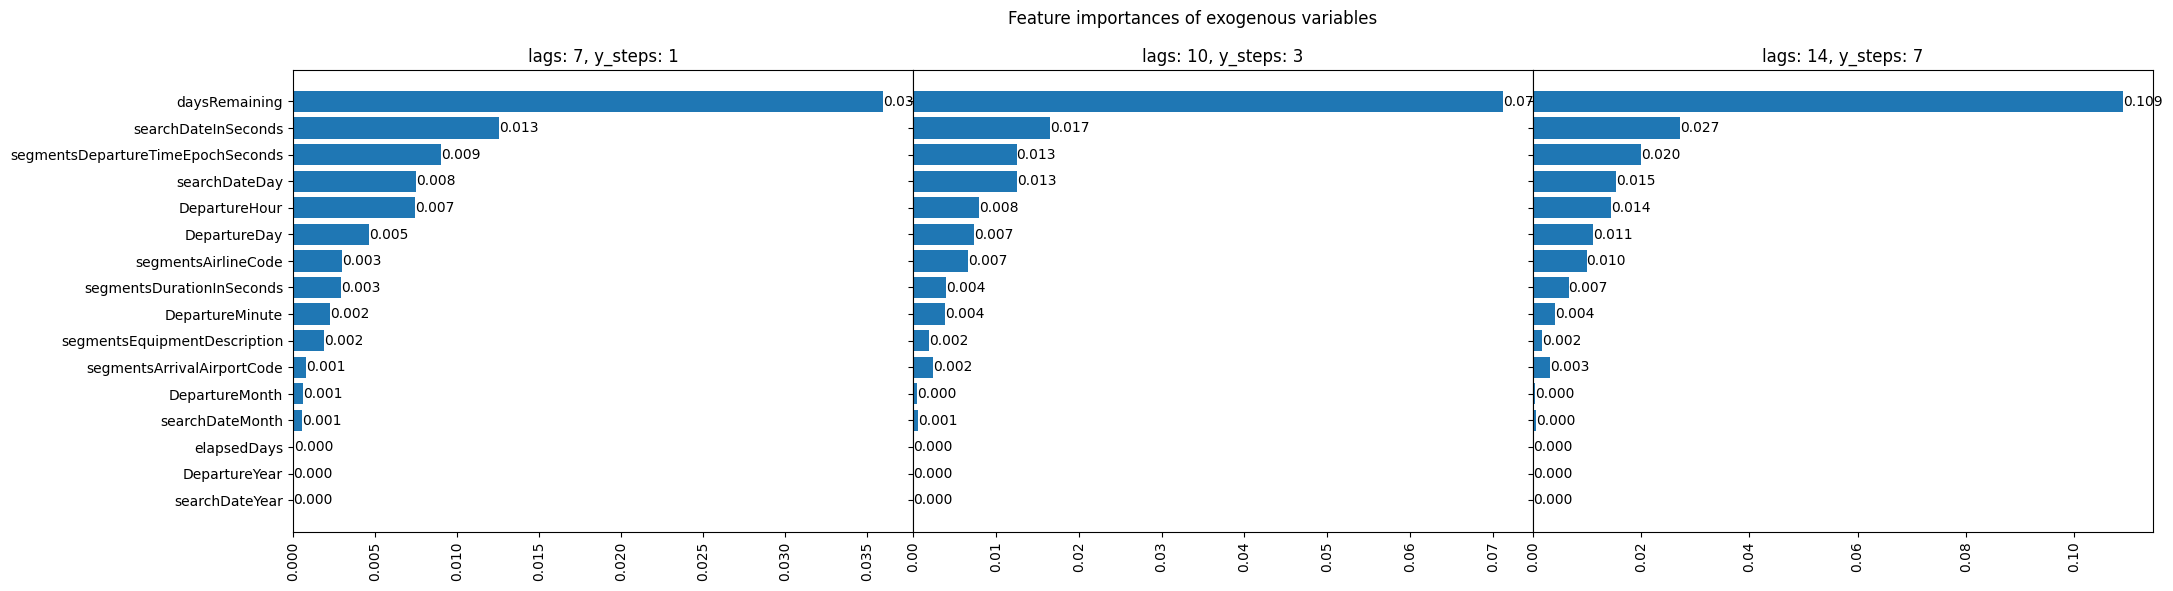

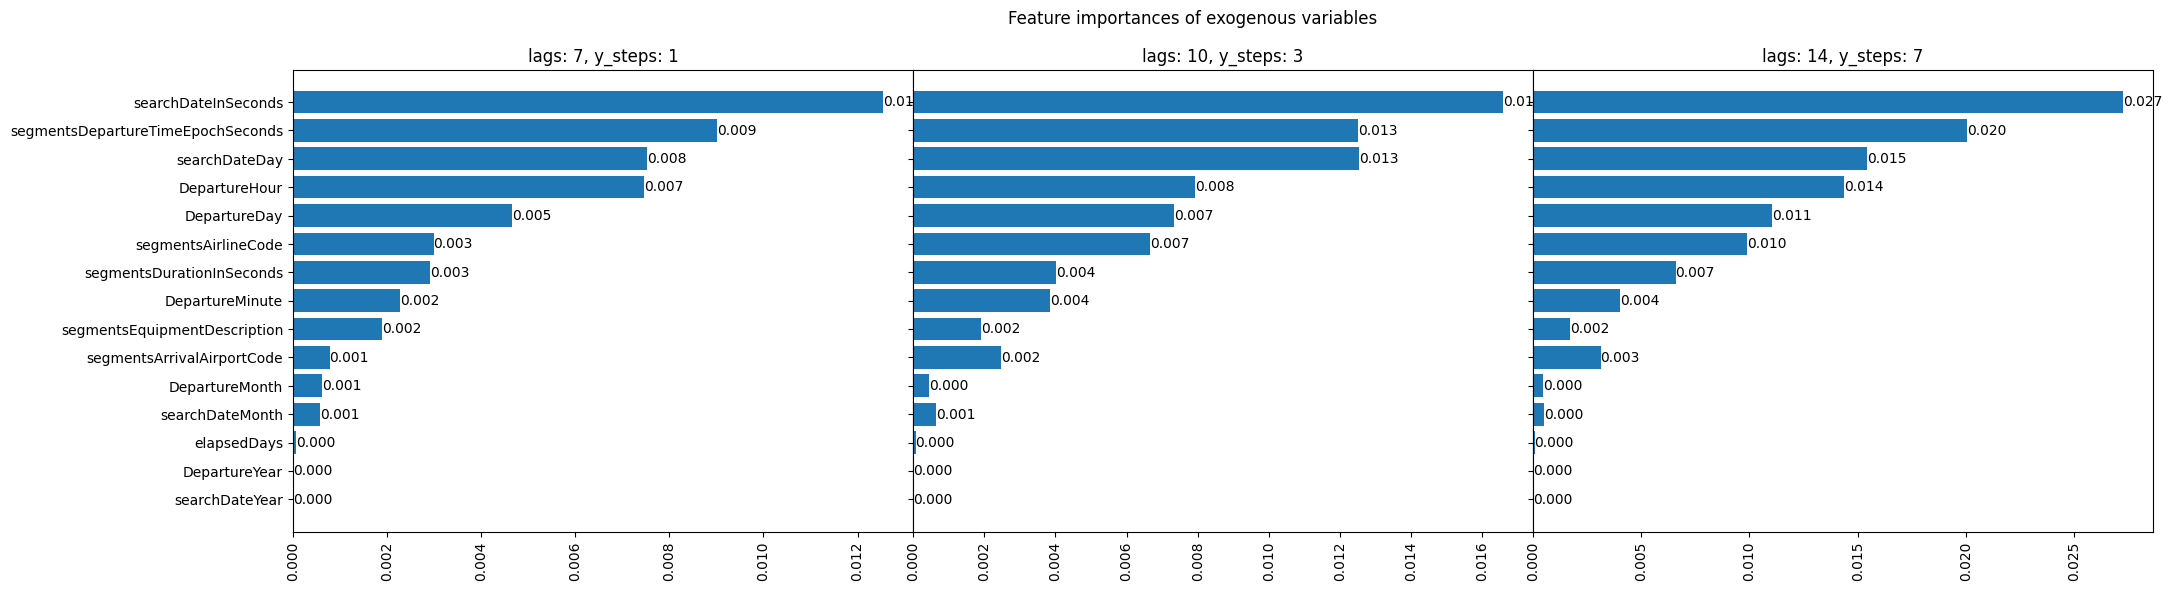

In [60]:
plot_exog_importance(*res)
plot_exog_importance(*res, exclude_first=True)

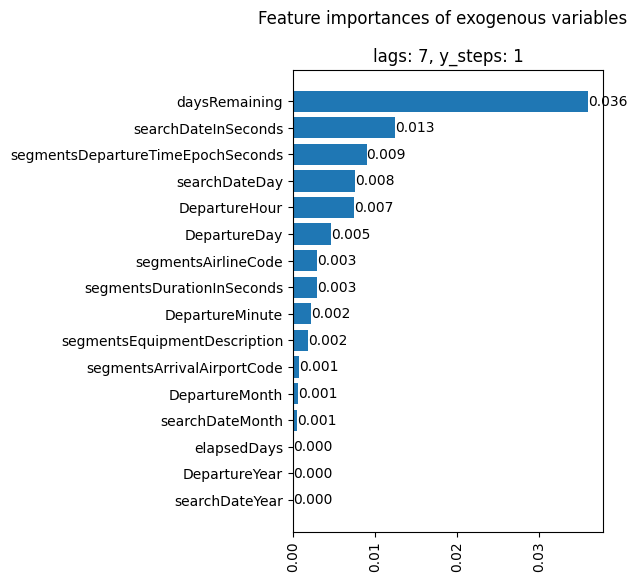

In [22]:
plot_exog_importance(*importances_diff_lags_y_steps([7], [1]), figsize=(4, 6))

In [3]:
from sklearn.inspection import permutation_importance

forest = RandomForestRegressor(bootstrap=False, n_jobs=5)
X_train, y_train = ts_trans.train_X_y(_df)
forest.fit(X_train, y_train)

result = permutation_importance(
    forest, X_train, y_train, n_jobs=1
)

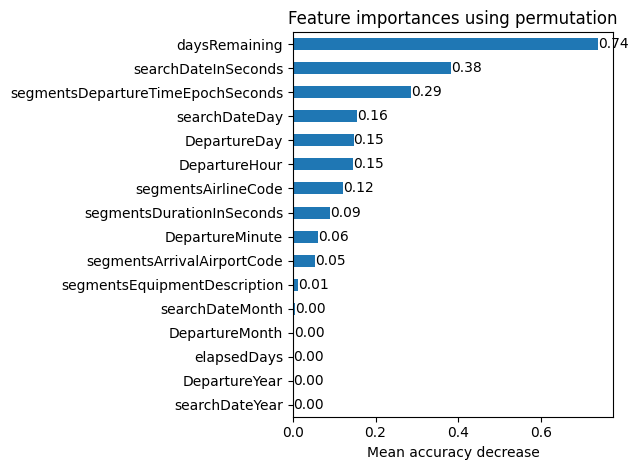

In [19]:
# Ref: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
forest_importances = pd.Series(result.importances_mean, index=ts_trans.X_columns)[2*ts_trans.lags:].sort_values()

fig, ax = plt.subplots()
forest_importances.plot.barh(ax=ax)
ax.set_title("Feature importances using permutation")
ax.set_xlabel("Mean accuracy decrease")
for bars in ax.containers:
    ax.bar_label(bars, fmt="%.2f")
fig.tight_layout()

# Conclusion of this section
**Comparison between time encoding methods**
* daysRemaing still showed great importance
* Seems convert timestamp to epoch seconds is good idea. Both correlation coefficients and feature imoprtance showed great significance.
* Split timestamp into different features did not gain improvements

**Following time features were adopted:**
* daysRemaining
* searchDateInSeconds
* segmentsDepartureTimeEpochSeconds

**Those features without significant influence will be removed:**
* elapsedDays
* segmentsArrivalAirportCode
* segmentsEquipmentDescription


# Build models
Prepare datasets for training models

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder

filled_df = pd.read_parquet("filled_df.parquet")
minor_features = [
    "totalTravelDistance",
    "elapsedDays",
    "segmentsArrivalAirportCode",
    "segmentsArrivalTimeEpochSeconds",
    "segmentsEquipmentDescription",
    "segmentsDepartureTimeRaw",
    "segmentsArrivalTimeRaw",
    
]
filled_df.drop(columns=minor_features, inplace=True)

def calc_days_remaining(df: pd.DataFrame):
    df["daysRemaining"] = pd.to_timedelta(
        pd.to_datetime(df["segmentsDepartureTimeEpochSeconds"], unit="s")
        - pd.to_datetime(df.index.get_level_values(level=1))
    ).dt.days.astype(np.float32)

def searchDate_to_seconds(df: pd.DataFrame):
    date_index = pd.to_datetime(df.index.get_level_values(1))
    df["searchDateInSeconds"] = (date_index - pd.to_datetime("1970-01-01")).total_seconds()

calc_days_remaining(filled_df)
searchDate_to_seconds(filled_df)

categorical_features = ["segmentsAirlineCode"]

ord_enc = OrdinalEncoder()
filled_df[categorical_features] = ord_enc.fit_transform(filled_df[categorical_features])
filled_df = filled_df.astype(np.float32)

This step takes a while. I suggest that skip to next CHECKPOINT

In [10]:
from datetime import timedelta

ONEDAY = timedelta(1)

def force_continuous_dates(_id):
    subframe = filled_df.loc[_id]
    full_dates = pd.date_range(subframe.index.min(), subframe.index.max())
    if subframe.shape[0] == full_dates.shape[0]:
        subframe_dict[_id] = subframe
        return
    frame_sections = []
    prev_pos = 0
    prev_date = subframe.index.min() - ONEDAY
    for pos, date in enumerate(subframe.index):
        time_diff = date - prev_date
        if time_diff == ONEDAY:
            prev_date = date
            continue
        frame_sections.append(subframe.iloc[prev_pos:pos])
        prev_pos = pos
        step = (subframe.iloc[pos] - subframe.iloc[pos-1]) / time_diff.days
        gap_frame = pd.DataFrame(
            [i * step for i in range(1, time_diff.days)],
            columns=filled_df.columns,
            index=pd.date_range(prev_date+ONEDAY, date-ONEDAY)
        )
        gap_frame += subframe.iloc[pos-1]
        frame_sections.append(gap_frame)
        prev_date = date
    frame_sections.append(subframe.iloc[prev_pos:])
    
    return pd.concat(frame_sections)

subframe_dict = {}
for _id in filled_df.index.get_level_values(0).unique():
    subframe_dict[_id] = force_continuous_dates(_id)

full_df = pd.concat(subframe_dict)
full_df.to_parquet("full_df.parquet")

### Test if the index order preserved
passed

還是 numpy 最香了

In [11]:
def sort_multi_index(df: pd.DataFrame):
    index = df.index

    min_max_record = {}
    for level0, level1 in index:
        if level0 not in min_max_record:
            min_max_record[level0] = [level1, pd.to_datetime("1970-01-01")]
        if level1 > min_max_record[level0][1]:
            min_max_record[level0][1] = level1
        elif level1 < min_max_record[level0][0]:
            min_max_record[level0][0] = level1

    level0_arr = index.get_level_values(0).unique().to_numpy()
    key_arr = np.array([min_max_record[name] for name in level0_arr])
    ind = np.lexsort((key_arr[:, 1], key_arr[:, 0]))
    return df.loc[level0_arr[ind]]

test_frame = sort_multi_index(full_df)
pd.testing.assert_frame_equal(test_frame, full_df)

# CHECKPOINT: prepare dataset for training

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

full_df = pd.read_parquet("full_df.parquet")

dataset = full_df

# TimeSeriesTransformer
他會負責所有關於 dataset 的 metadata 以及轉換

In [2]:
from tstide.transformer import TimeSeriesTransformer

ts_trans = TimeSeriesTransformer(
    10,
    ["totalFare", "seatsRemaining"],
    [
        "segmentsDepartureTimeEpochSeconds",
        "segmentsAirlineCode",
        "segmentsDurationInSeconds",
        "daysRemaining",
        "searchDateInSeconds",
    ],
    ["daysRemaining", "searchDateInSeconds"],
    y_steps=3
)

## mae of 7 days in 5 validation sets
我還不確定能不能動，因為後來有改過一些東西

In [8]:
from typing import Literal
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# EchoRegressor 只會重複 X 中最後一天的答案，也就是瞎猜價格及剩餘位置都維持現狀
# 不能輸給瞎猜
from tstide.forecast import EchoRegressor
from tstide.forecast._sklearn import forecast, valid_folds

valid_set_1  = next(valid_folds(dataset, pd.to_datetime(dataset.index.get_level_values(1))))
X_train, y_train, trailing_data = ts_trans.train_test_split(valid_set_1, 7)

forest = RandomForestRegressor(bootstrap=False, n_jobs=14)
forest.fit(X_train, y_train)

y_true_arr = ts_trans.extract_y_true(trailing_data)
rec_pred = forecast(forest, trailing_data, ts_trans, method="recursive")
rol_pred = forecast(forest, trailing_data, ts_trans, method="rolling")
echo_pred = forecast(EchoRegressor(10, 3), trailing_data, ts_trans, method="recursive")

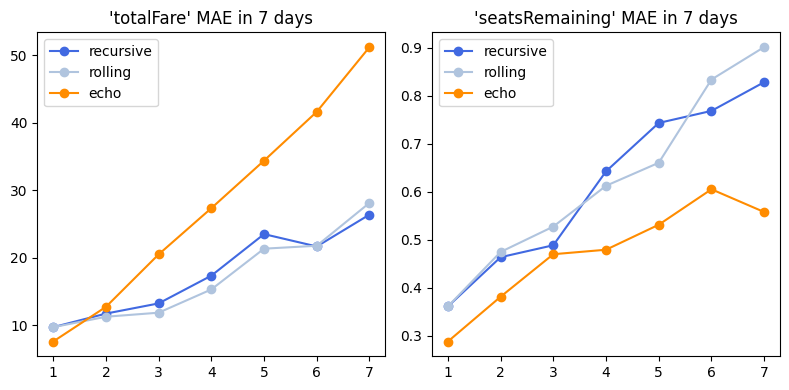

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def calc_mae(
    y_true_arr,
    y_pred_arr,
    multioutput: Literal["uniform_average", "raw_values"] = "uniform_average"
):
    FARE = 0
    SEAT = 1
    mae_arr = np.array([
        mean_absolute_error(y_true_arr[FARE], y_pred_arr[FARE], multioutput=multioutput),
        mean_absolute_error(y_true_arr[SEAT], y_pred_arr[SEAT], multioutput=multioutput),
    ])
    return mae_arr

FARE = 0
SEAT = 1

mae_recursive = calc_mae(y_true_arr, rec_pred, "raw_values")
mae_rolling = calc_mae(y_true_arr, rol_pred, "raw_values")
mae_echo = calc_mae(y_true_arr, echo_pred, "raw_values")

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
x_axis = np.arange(1, 8)
axes[0].plot(x_axis, mae_recursive[FARE], marker="o", label="recursive", color="royalblue")
axes[0].plot(x_axis, mae_rolling[FARE], marker="o", label="rolling", color="lightsteelblue")
axes[0].plot(x_axis, mae_echo[FARE], marker="o", label="echo", color="darkorange")
axes[0].set_title("'totalFare' MAE in 7 days")
axes[0].legend()

axes[1].plot(x_axis, mae_recursive[SEAT], marker="o", label="recursive", color="royalblue")
axes[1].plot(x_axis, mae_rolling[SEAT], marker="o",  label="rolling", color="lightsteelblue")
axes[1].plot(x_axis, mae_echo[SEAT], marker="o", label="echo", color="darkorange")
axes[1].set_title("'seatsRemaining' MAE in 7 days")
axes[1].legend()
fig.tight_layout()

# Cross validation: backtesting
要跑很久

In [3]:
from tstide.forecast._sklearn import backtesting
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(bootstrap=False, n_jobs=14)

rec_pred_list = backtesting(forest, full_df, ts_trans)
rol_pred_list = backtesting(forest, full_df, ts_trans)


Result above are stored

In [18]:
# 把 y_true 從 backtesting 建立的 cache 叫出來
cached_data = backtesting(None, None, None, return_cache=True)
y_true_list = [
    ts_trans.extract_y_true(cached_data[(10, 3)]["trailing_data"][i]) for i in range(5)
]

In [19]:
import joblib

joblib.dump(rec_pred_list, "forest_10_3_rec.gz")
joblib.dump(rol_pred_list, "forest_10_3_rol.gz")
joblib.dump(y_true_list, "y_true_10_3.gz")

['y_true_10_3.gz']

In [7]:
import joblib

load_rec = joblib.load("forest_10_3_rec.gz")

### 下面可能不會動
這些是比較早期的 code，有些自己寫的函式有改過而可能會噴 error

<Axes: >

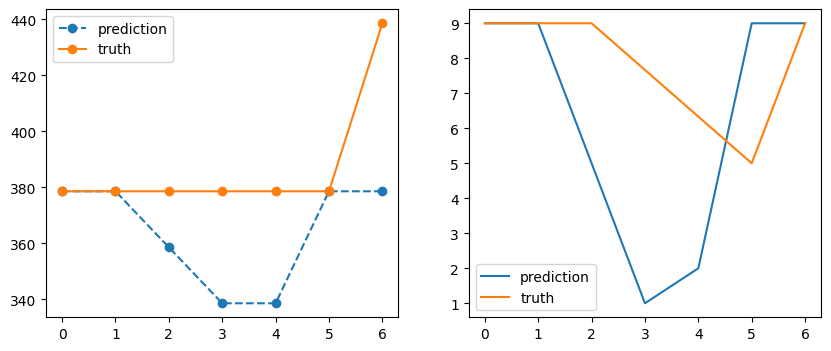

In [41]:
from tstide.forecast._sklearn import recursive_predict, rolling_predict

y_true = trailing_data.loc[["2c616c5aff360bc81286c04dd10a33aa"], ["totalFare", "seatsRemaining"]].to_numpy()[-7:]
y_pred = recursive_predict(forest, trailing_data, 7, ts_trans)[["totalFare", "seatsRemaining"]].to_numpy()[-7:]

pred_truth = pd.DataFrame(
    np.vstack([y_pred[:, 0], y_true[:, 0], y_pred[:, 1], y_true[:, 1]]).T,
    columns=pd.MultiIndex.from_product([["totalFare", "seatsRemaining"], ["prediction", "truth"]])
)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

pred_truth["totalFare"]["prediction"].plot(ax=axes[0], marker="o", ls="--")
pred_truth["totalFare"]["truth"].plot(ax=axes[0], marker="o")
axes[0].legend()
pred_truth["seatsRemaining"].plot(ax=axes[1])

<Axes: >

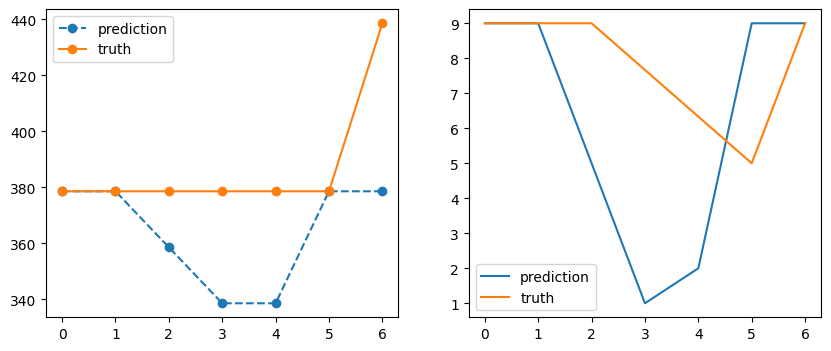

In [42]:
y_true = trailing_data.loc[["2c616c5aff360bc81286c04dd10a33aa"], ["totalFare", "seatsRemaining"]].to_numpy()[-7:]
y_pred = rolling_predict(forest, trailing_data, 7, ts_trans)[["totalFare", "seatsRemaining"]].to_numpy()[-7:]

pred_truth = pd.DataFrame(
    np.vstack([y_pred[:, 0], y_true[:, 0], y_pred[:, 1], y_true[:, 1]]).T,
    columns=pd.MultiIndex.from_product([["totalFare", "seatsRemaining"], ["prediction", "truth"]])
)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

pred_truth["totalFare"]["prediction"].plot(ax=axes[0], marker="o", ls="--")
pred_truth["totalFare"]["truth"].plot(ax=axes[0], marker="o")
axes[0].legend()
pred_truth["seatsRemaining"].plot(ax=axes[1])